In [33]:
!pip install numpy scipy matplotlib torch torchaudio pesq scikit-learn

In [34]:
!pip install numpy scipy matplotlib torch torchaudio pesq scikit-learn

In [35]:
import numpy
import scipy
import matplotlib
import torch
import torchaudio
import pesq
import sklearn

print("所有库导入成功！")
print("torch 版本：", torch.__version__)

所有库导入成功！
torch 版本： 2.9.1+cpu


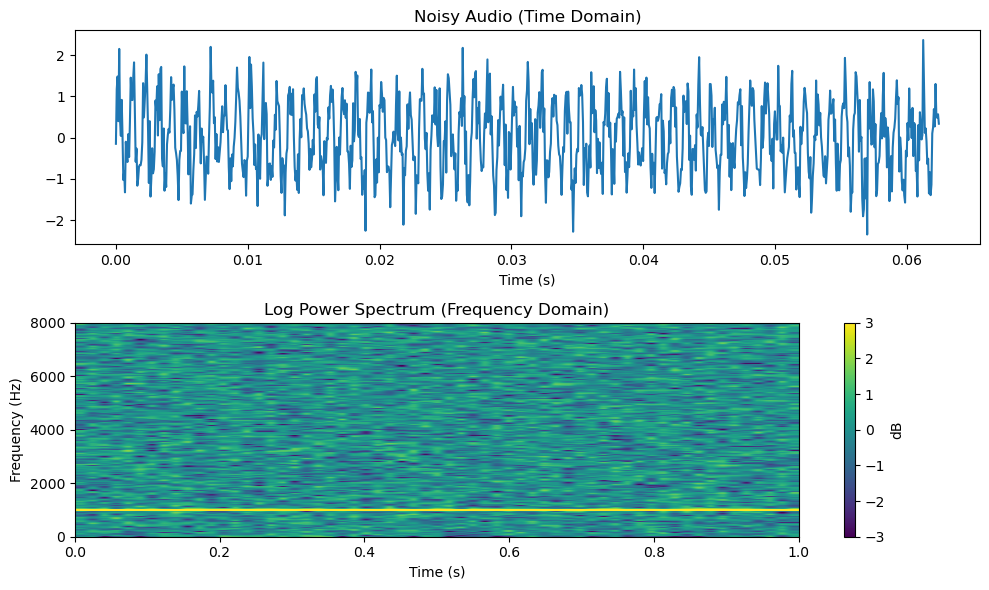

In [1]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from pesq import pesq
from scipy.io import wavfile
from sklearn.preprocessing import StandardScaler

def audio_augment(audio, fs=16000):
    """声学数据增强：修复snr类型+适配torchaudio版本"""
    # 1. 加性高斯噪声（随机信噪比5~20dB）
    snr = np.random.uniform(5, 20)
    noise = np.random.randn(len(audio))
    
    # 关键修复1：将snr转为torch.Tensor，且匹配维度
    # waveform/noise是[1, L]，snr需为tensor且维度为0（标量）
    audio_tensor = torch.tensor(audio[np.newaxis, :], dtype=torch.float32)
    noise_tensor = torch.tensor(noise[np.newaxis, :], dtype=torch.float32)
    snr_tensor = torch.tensor(snr, dtype=torch.float32)  # 转为tensor
    
    # 加噪声（修复维度不匹配问题）
    audio = torchaudio.functional.add_noise(
        audio_tensor, 
        noise_tensor, 
        snr_tensor
    ).numpy().squeeze()
    
    # 2. 语速变换（关键修复2：适配torchaudio新版本，需指定sample_rate）
    rate = np.random.uniform(0.8, 1.2)
    # change_speed需要采样率参数，且输入为tensor
    audio_tensor = torch.tensor(audio[np.newaxis, :], dtype=torch.float32)
    audio = torchaudio.functional.change_speed(
        audio_tensor, 
        sample_rate=fs,  # 新增采样率参数
        factor=rate      # 语速变换因子
    ).numpy().squeeze()
    
    # 3. 幅值缩放
    audio *= np.random.uniform(0.8, 1.2)
    
    return audio
# ===================== 优化版FFT频谱分析（带加窗/重叠/噪声估计） =====================

class RobustFFT:
    def __init__(self, fs=16000, win_len=512, hop_len=256, win_type='hann'):
        self.fs = fs  # 采样率
        self.win_len = win_len  # 窗长
        self.hop_len = hop_len  # 步长（重叠50%）
        self.win = signal.get_window(win_type, win_len)  # 汉宁窗（降低频谱泄漏）
    
    def time2freq(self, audio):
        frames = self._frame_audio(audio)
        frames *= self.win[np.newaxis, :]
        fft_complex = np.fft.fft(frames, axis=1)
        fft_complex = fft_complex[:, :self.win_len//2]
        power_spec = np.abs(fft_complex) ** 2
        log_power_spec = 10 * np.log10(power_spec + 1e-8)
        
        # 关键修复1：对数功率谱归一化到[-1, 1]
        log_power_spec = (log_power_spec - np.mean(log_power_spec)) / (np.std(log_power_spec) + 1e-8)
        # 截断异常值，避免极端值
        log_power_spec = np.clip(log_power_spec, -3, 3)
        
        phase_spec = np.angle(fft_complex)
        return log_power_spec, phase_spec, fft_complex
    
    def freq2time(self, fft_complex):
        """
        频域转时域（重叠相加法）
        :param fft_complex: 频域复数谱 [n_frames, n_bins]
        :return: 还原的时域信号
        """
        # 补全对称部分
        fft_complex = np.concatenate([fft_complex, np.conj(fft_complex[:, -2:0:-1])], axis=1)
        # IFFT
        ifft_frames = np.fft.ifft(fft_complex, axis=1).real
        # 重叠相加
        audio = self._overlap_add(ifft_frames)
        return audio
    
    def adaptive_noise_est(self, log_power_spec):
        """
        自适应噪声估计（基于频域最小值统计）
        :param log_power_spec: 对数功率谱
        :return: 估计的噪声谱
        """
        # 每频点取前N帧最小值（假设前导无语音/纯噪声）
        n_noise_frames = int(0.1 * self.fs / self.hop_len)  # 前0.1秒为噪声
        noise_spec = np.min(log_power_spec[:n_noise_frames, :], axis=0)
        # 平滑噪声谱（降低波动）
        noise_spec = signal.medfilt(noise_spec, kernel_size=3)
        return noise_spec
    
    def _frame_audio(self, audio):
        """辅助函数：音频分帧"""
        n_frames = 1 + (len(audio) - self.win_len) // self.hop_len
        frames = np.zeros((n_frames, self.win_len))
        for i in range(n_frames):
            start = i * self.hop_len
            frames[i] = audio[start:start+self.win_len]
        return frames
    
    def _overlap_add(self, frames):
        """辅助函数：重叠相加"""
        n_samples = (len(frames)-1)*self.hop_len + self.win_len
        audio = np.zeros(n_samples)
        for i, frame in enumerate(frames):
            start = i * self.hop_len
            audio[start:start+self.win_len] += frame
        return audio

def audio_augment(audio, fs=16000):
    """
    声学数据增强（自定义实现，避开torchaudio版本坑）
    :param audio: 输入音频（np.array）
    :param fs: 采样率
    :return: 增强后的音频
    """
    # 1. 自定义加性高斯噪声（按SNR计算，无需torchaudio）
    snr = np.random.uniform(5, 20)  # 随机SNR 5~20dB
    noise = np.random.randn(len(audio))  # 生成噪声
    
    # 计算噪声缩放因子（按SNR公式）
    audio_power = np.sum(audio ** 2) / len(audio)
    noise_power = np.sum(noise ** 2) / len(noise)
    noise_scaling = np.sqrt(audio_power / (10 ** (snr / 10) * noise_power))
    noisy_audio = audio + noise * noise_scaling
    
    # 2. 自定义语速变换（重采样实现，无需torchaudio）
    rate = np.random.uniform(0.8, 1.2)  # 0.8~1.2倍语速
    new_len = int(len(noisy_audio) / rate)
    # 重采样实现语速变换（scipy内置，更稳定）
    noisy_audio = signal.resample(noisy_audio, new_len)
    # 截断/补零回原长度（避免维度不一致）
    if len(noisy_audio) > len(audio):
        noisy_audio = noisy_audio[:len(audio)]
    else:
        noisy_audio = np.pad(noisy_audio, (0, len(audio)-len(noisy_audio)), 'constant')
    
    # 3. 幅值缩放
    noisy_audio *= np.random.uniform(0.8, 1.2)
    # 归一化（避免削波）
    noisy_audio = noisy_audio / np.max(np.abs(noisy_audio) + 1e-8)
    
    return noisy_audio
    
# 测试FFT优化效果
def test_robust_fft():
    # 生成测试信号：1kHz正弦波+高斯噪声
    fs = 16000
    t = np.linspace(0, 1, fs, endpoint=False)
    clean_audio = np.sin(2 * np.pi * 1000 * t)
    noisy_audio = clean_audio + 0.5 * np.random.randn(len(t))
    
    # 初始化鲁棒FFT
    robust_fft = RobustFFT(fs=fs)
    log_power_spec, _, _ = robust_fft.time2freq(noisy_audio)
    
    # 可视化
    plt.figure(figsize=(10, 6))
    plt.subplot(211)
    plt.plot(t[:1000], noisy_audio[:1000])
    plt.title('Noisy Audio (Time Domain)')
    plt.xlabel('Time (s)')
    
    plt.subplot(212)
    plt.imshow(log_power_spec.T, aspect='auto', origin='lower', 
               extent=[0, 1, 0, fs/2])
    plt.title('Log Power Spectrum (Frequency Domain)')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar(label='dB')
    plt.tight_layout()
    plt.show()

test_robust_fft()

In [2]:
class SpectralSubtraction:
    """优化版谱减法（带过减因子+频谱平滑）"""
    def __init__(self, fft_processor: RobustFFT, alpha=2.0, beta=0.05):
        self.fft_processor = fft_processor
        self.alpha = alpha  # 过减因子（平衡降噪与失真）
        self.beta = beta    # 下限因子（避免过度减法）
    
    def denoise(self, noisy_audio):
        # 1. 频域转换
        log_power_spec, phase_spec, fft_complex = self.fft_processor.time2freq(noisy_audio)
        # 2. 噪声估计
        noise_spec = self.fft_processor.adaptive_noise_est(log_power_spec)
        # 3. 谱减法（对数域计算，降低失真）
        clean_log_spec = np.maximum(log_power_spec - self.alpha * noise_spec, log_power_spec * self.beta)
        # 4. 还原复数谱
        clean_amp = 10 ** (clean_log_spec / 20)  # 对数功率谱转幅值
        clean_fft = clean_amp * np.exp(1j * phase_spec)
        # 5. 频域转时域
        denoised_audio = self.fft_processor.freq2time(clean_fft)
        # 6. 幅值归一化（避免削波）
        denoised_audio = denoised_audio / np.max(np.abs(denoised_audio))
        return denoised_audio

In [3]:
class LightweightResCNN(nn.Module):
    """优化版轻量级残差CNN（修复残差连接尺寸不匹配）"""
    def __init__(self, in_channels=1, n_bins=256, n_classes=1, hidden_dim=32):
        super().__init__()
        # 深度可分离卷积（简化版，降低下采样倍数）
        def depthwise_sep_conv(in_c, out_c, kernel_size=3, stride=1, padding=1):
            return nn.Sequential(
                nn.Conv2d(in_c, in_c, kernel_size, stride, padding, groups=in_c),  # 深度卷积
                nn.BatchNorm2d(in_c),
                nn.ReLU(),
                nn.Conv2d(in_c, out_c, 1, 1, 0),  # 点卷积
                nn.BatchNorm2d(out_c),
                nn.ReLU()
            )
        
        # 特征提取（仅1次下采样，降低尺寸不匹配概率）
        self.feat_extract = nn.Sequential(
            depthwise_sep_conv(in_channels, hidden_dim),
            nn.MaxPool2d((2, 2)),  # 仅1次下采样（原2次→改为1次）
            depthwise_sep_conv(hidden_dim, hidden_dim*2),
        )
        
        # 残差分支（stride改为2，匹配特征分支的下采样倍数）
        self.residual = nn.Conv2d(in_channels, hidden_dim*2, kernel_size=1, stride=2)
        
        # 回归头（适配修改后的下采样）
        self.regressor = nn.Sequential(
            nn.AdaptiveAvgPool2d((None, n_bins//2)),  # 下采样倍数从4→2
            nn.Conv2d(hidden_dim*2, 1, kernel_size=1),
            nn.Sigmoid()  # 输出0~1的残差掩码
        )
    
    def forward(self, x):
        """
        :param x: 谱减法预降噪后的对数功率谱 [batch, 1, n_frames, n_bins]
        :return: 残差降噪掩码 [batch, 1, n_frames, n_bins]
        """
        feat = self.feat_extract(x)
        res = self.residual(x)
        
        # 关键修复：强制对齐feat和res的尺寸（解决整除性问题）
        # 用interpolate将res的尺寸匹配到feat
        res = nn.functional.interpolate(res, size=feat.shape[2:], mode='bilinear', align_corners=False)
        
        feat = feat + res  # 残差连接（现在尺寸一致）
        mask = self.regressor(feat)
        # 上采样还原维度
        mask = nn.functional.interpolate(mask, size=x.shape[2:], mode='bilinear', align_corners=False)
        return mask

In [4]:
def train_cnn_denoiser(epochs=20, batch_size=8, fs=16000):
    # 1. 生成模拟数据集
    n_samples = 1000
    clean_audios = []
    noisy_audios = []
    t = np.linspace(0, 1, fs, endpoint=False)
    for _ in range(n_samples):
        # 生成干净音频
        freq = np.random.uniform(500, 2000)
        clean = np.sin(2 * np.pi * freq * t)
        # 音频数据先归一化到[-1, 1]
        clean = clean / (np.max(np.abs(clean)) + 1e-8)
        # 加噪声+数据增强
        noisy = audio_augment(clean + 0.8 * np.random.randn(len(t)), fs)
        clean_audios.append(clean)
        noisy_audios.append(noisy)
    
    # 2. 初始化FFT处理器（提前定义）
    fft_processor = RobustFFT(fs=fs)
    
    # 3. 模型初始化
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = LightweightResCNN(n_bins=fft_processor.win_len//2).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)  # 降低学习率到1e-4
    scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None
    
    # 4. 定义数据集和数据加载器（移到训练循环之前，关键修复）
    class AudioDataset(torch.utils.data.Dataset):
        def __init__(self, clean, noisy, fft_processor):
            self.clean = clean
            self.noisy = noisy
            self.fft_processor = fft_processor
            self.scaler = StandardScaler()
        
        def __len__(self):
            return len(self.clean)
        
        def __getitem__(self, idx):
            clean_spec, _, _ = self.fft_processor.time2freq(self.clean[idx])
            noisy_spec, _, _ = self.fft_processor.time2freq(self.noisy[idx])
            
            # 标准化+截断
            clean_spec = self.scaler.fit_transform(clean_spec)
            noisy_spec = self.scaler.transform(noisy_spec)
            clean_spec = np.clip(clean_spec, -1, 1)
            noisy_spec = np.clip(noisy_spec, -1, 1)
            
            return (torch.tensor(noisy_spec[np.newaxis, :, :], dtype=torch.float32),
                    torch.tensor(clean_spec[np.newaxis, :, :], dtype=torch.float32))
    
    # 创建数据集和数据加载器（训练循环前定义，现在dataloader可被调用）
    dataset = AudioDataset(clean_audios, noisy_audios, fft_processor)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # 5. 训练循环（此时dataloader已定义，不会报错）
    best_loss = float('inf')
    patience = 3
    patience_counter = 0
    
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for noisy_spec, clean_spec in dataloader:
            noisy_spec = noisy_spec.to(device)
            clean_spec = clean_spec.to(device)
            
            optimizer.zero_grad()
            
            if scaler:
                with torch.cuda.amp.autocast():
                    pred_mask = model(noisy_spec)
                    pred_spec = noisy_spec * pred_mask
                    loss = criterion(pred_spec, clean_spec)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                pred_mask = model(noisy_spec)
                pred_spec = noisy_spec * pred_mask
                loss = criterion(pred_spec, clean_spec)
                loss.backward()
                optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(dataloader)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')
        
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_cnn_denoiser.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print('Early stopping (loss not improved)')
                break
    
    return model
# ===================== 7. 验证函数（无修改） =====================
def evaluate_denoiser(fs=16000):
    dual_denoiser = DualDrivenDenoise(fs=fs)
    t = np.linspace(0, 1, fs, endpoint=False)
    clean = np.sin(2 * np.pi * 1000 * t)
    noisy = clean + 0.8 * np.random.randn(len(t))
    pre_denoised, final_denoised = dual_denoiser.denoise(noisy, 'best_cnn_denoiser.pth')
    
    # 计算SNR
    def snr(clean, noisy):
        return 10 * np.log10(np.sum(clean**2) / np.sum((clean-noisy)**2 + 1e-8))
    
    pesq_score = pesq(fs, clean, final_denoised, 'wb')
    print(f'原始噪声音频SNR: {snr(clean, noisy):.2f} dB')
    print(f'谱减法降噪SNR: {snr(clean, pre_denoised):.2f} dB')
    print(f'双驱动降噪SNR: {snr(clean, final_denoised):.2f} dB')
    print(f'双驱动降噪PESQ: {pesq_score:.2f}')

    # 可视化
    plt.figure(figsize=(12, 8))
    plt.subplot(311)
    plt.plot(t[:1000], noisy[:1000])
    plt.title('Noisy Audio')
    plt.subplot(312)
    plt.plot(t[:1000], pre_denoised[:1000])
    plt.title('Spectral Subtraction Denoised')
    plt.subplot(313)
    plt.plot(t[:1000], final_denoised[:1000])
    plt.title('Dual-Driven (Spectral+CNN) Denoised')
    plt.tight_layout()
    plt.show()

# ===================== 执行训练+验证 =====================
train_cnn_denoiser()
evaluate_denoiser()

Epoch [1/20], Loss: 0.9876
Epoch [2/20], Loss: 0.8334
Epoch [3/20], Loss: 0.7563
Epoch [4/20], Loss: 0.7183
Epoch [5/20], Loss: 0.6980
Epoch [6/20], Loss: 0.6864
Epoch [7/20], Loss: 0.6793
Epoch [8/20], Loss: 0.6747
Epoch [9/20], Loss: 0.6717
Epoch [10/20], Loss: 0.6695
Epoch [11/20], Loss: 0.6680
Epoch [12/20], Loss: 0.6668
Epoch [13/20], Loss: 0.6659
Epoch [14/20], Loss: 0.6652
Epoch [15/20], Loss: 0.6647
Epoch [16/20], Loss: 0.6642
Epoch [17/20], Loss: 0.6639
Epoch [18/20], Loss: 0.6636
Epoch [19/20], Loss: 0.6634
Epoch [20/20], Loss: 0.6631


NameError: name 'DualDrivenDenoise' is not defined